In [1]:
using InstantiateFromURL
github_project("mmikhasenko/Introduction2AmplitudeAnalysis")

┌ Info: Precompiling InstantiateFromURL [43edad99-fa64-5e4f-9937-1c09a410b73f]
└ @ Base loading.jl:1278


Activated C:\Users\mikha\Documents\Introduction2AmplitudeAnalysis\Project.toml
Info Project name is NA, version is NA


In [16]:
using DelimitedFiles
using TypedTables
using Plots
using Optim
using Parameters

In [100]:
theme(:wong)

# Resonance analysis

## Example: COMPASS $\eta\pi$ scattering. $a_2\to \eta\pi$

In [7]:
const tdata = let
    M = readdlm(joinpath("data", "EtaPi-2pp_arxiv1408.4286.txt"))
    Table(mηπ = M[:,1], I = M[:,2], δI = M[:,3])
end

Table with 3 columns and 56 rows:
      mηπ   I         δI
    ┌────────────────────────
 1  │ 0.76  28.1815   45.1663
 2  │ 0.8   195.166   98.0546
 3  │ 0.84  148.642   78.0067
 4  │ 0.88  314.183   110.135
 5  │ 0.92  637.512   153.007
 6  │ 0.96  746.056   142.807
 7  │ 1.0   1172.9    191.095
 8  │ 1.04  2004.33   232.612
 9  │ 1.08  3450.18   253.672
 10 │ 1.12  5567.89   344.274
 11 │ 1.16  10658.5   425.27
 12 │ 1.2   22309.5   596.645
 13 │ 1.24  47960.0   945.249
 14 │ 1.28  104106.0  1377.29
 15 │ 1.32  127192.0  1528.69
 16 │ 1.36  78516.7   1101.86
 17 │ 1.4   41960.3   763.341
 18 │ 1.44  24652.8   631.313
 19 │ 1.48  16817.5   567.275
 20 │ 1.52  12156.7   467.563
 21 │ 1.56  11506.1   453.328
 22 │ 1.6   9175.1    447.977
 23 │ 1.64  10510.0   401.283
 ⋮  │  ⋮       ⋮         ⋮

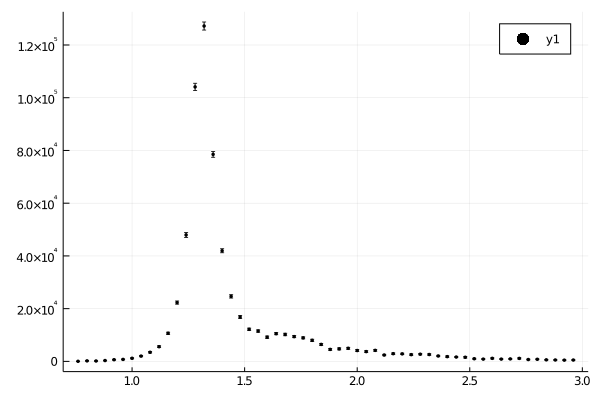

In [11]:
scatter(tdata.mηπ, tdata.I, yerr=tdata.δI, lc=:black, m=(2,:black))

In [52]:
const mπ = 0.140; # GeV
const mη = 0.547; # GeV

In [117]:
A(s; m, Γ) = m*Γ/(m^2-s-1im*m*Γ)
λ(x,y,z) = x^2+y^2+z^2-2x*y-2y*z-2z*x
function model(mηπ; pars)
    @unpack N0, m, Γ = pars
    #
    psq(x) = λ(x^2,mη^2,mπ^2)/(4x^2)
    bwf(z) = 1/(9+3z+z^2)
    FF(x;R = 3) = bwf(R^2*psq(x))/bwf(R^2*psq(m))
    #
    return abs2(N0*A(mηπ^2; m=m, Γ=Γ))*(psq(mηπ)/psq(m))^2*FF(mηπ)*sqrt(λ(mηπ^2,mη^2,mπ^2))/mηπ
end

model (generic function with 1 method)

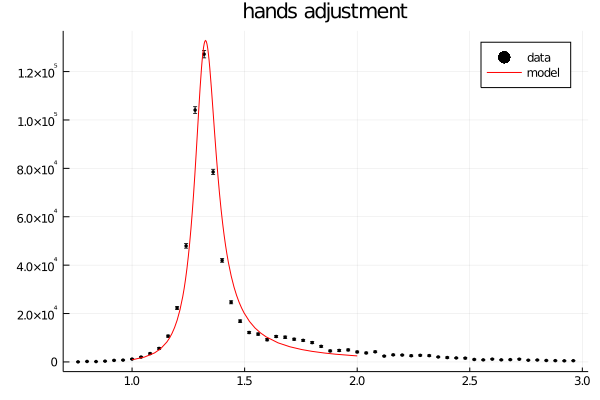

In [118]:
let pars = (N0 = 350, m=1.32,Γ=0.12)
    scatter(tdata.mηπ, tdata.I, yerr=tdata.δI, lc=:black, m=(2,:black), lab="data")
    plot!(mηπ->model(mηπ; pars=pars), 1.0,2.0, l=:red, lab="model", title="hands adjustment")
end

In [119]:
function loss(; data, pars)
    return sum((y - model(e; pars=pars))^2/δy^2 for (e, y, δy) in data)
#     return ((data.I - model.(data.mηπ; pars=pars)) ./ data.δI) .^2 
end

loss (generic function with 1 method)

In [120]:
loss(; data=filter(x->1.0<x.mηπ<1.5, tdata), pars=(m=1.32,Γ=0.12,N0=350))

2061.10641715955

In [121]:
fr = Optim.optimize(x->loss(; data=filter(x->1.0<x.mηπ<1.5, tdata), pars=(m=x[1],Γ=x[2],N0=x[3])),
    [1.32,0.12,350])

 * Status: success

 * Candidate solution
    Final objective value:     2.950896e+01

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    99
    f(x) calls:    194


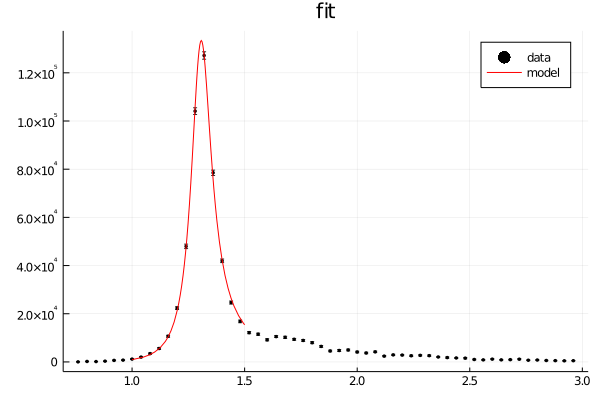

In [122]:
let pars=NamedTuple{(:m,:Γ,:N0)}(Optim.minimizer(fr))
    scatter(tdata.mηπ, tdata.I, yerr=tdata.δI, lc=:black, m=(2,:black), label="data")
    plot!(mηπ->model(mηπ;pars=pars), 1.0,1.5, l=:red, label="model", title="fit")
end

In [123]:
bestmodel(mηπ) = model(mηπ; pars=NamedTuple{(:m,:Γ,:N0)}(Optim.minimizer(fr)))
bestA(mηπ) = A(mηπ^2; NamedTuple{(:m,:Γ)}(Optim.minimizer(fr)[1:2])...)

bestA (generic function with 1 method)

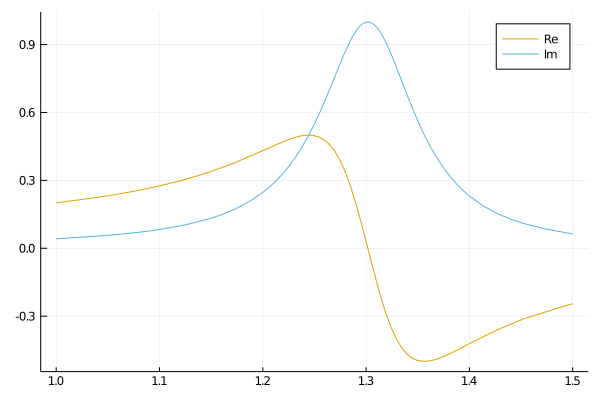

In [124]:
let
    plot()
    plot!(x->real(bestA(x)), 1.0,1.5, lab="Re")
    plot!(x->imag(bestA(x)), 1.0,1.5, lab="Im")
end

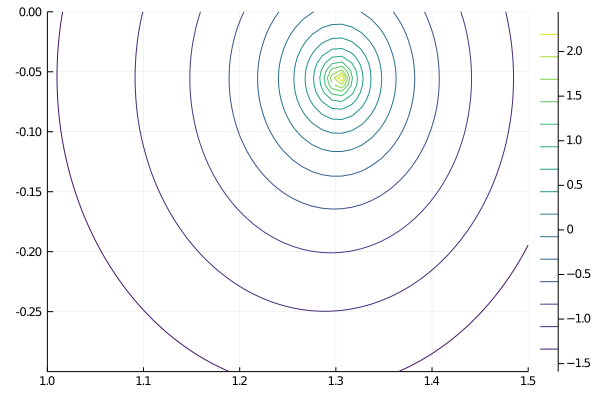

In [125]:
let
    realmv = range(1.0,1.5, length=50)
    imagmv = range(-0.3,0, length=50)
    calv = [bestA(r+1im*i) for i in imagmv, r in realmv]
    calv = log10.(abs2.(calv))
    contour(realmv, imagmv, calv)
end

In [126]:
pole_fr = Optim.optimize(x->abs2(1/bestA(x[1]+1im*x[2])), [1.3, -0.06])

 * Status: success

 * Candidate solution
    Final objective value:     9.162518e-10

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    29
    f(x) calls:    61


In [127]:
Optim.minimizer(pole_fr) .* [1, -2]

2-element Array{Float64,1}:
 1.3028689365591615
 0.11167301526869139

## $a_2'$ getting the higher-mass resonances

In [139]:
A2(s; ps) = 1/(sum(p*s^(i-1) for (i,p) in enumerate(ps))-1im)
function model2(mηπ; pars)
    @unpack N0, ps = pars
    #
    psq(x) = λ(x^2,mη^2,mπ^2)/(4x^2)
    bwf(z) = 1/(9+3z+z^2)
    FF(x;R = 3) = bwf(R^2*psq(x))
    #
    return abs2(N0*A2(mηπ^2; ps=ps))*(psq(mηπ))^2*FF(mηπ)*sqrt(λ(mηπ^2,mη^2,mπ^2))/mηπ
end

model2 (generic function with 1 method)

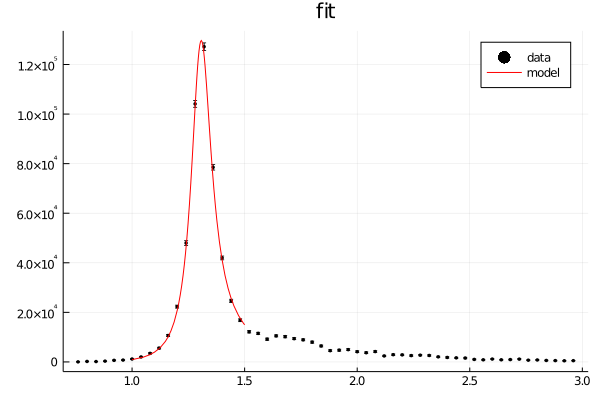

In [148]:
let 
    m, Γ, N0 = Optim.minimizer(fr)
    pars=(ps = [m^2/(m*Γ), -1/(m*Γ), 0], N0=17*N0)
    scatter(tdata.mηπ, tdata.I, yerr=tdata.δI, lc=:black, m=(2,:black), label="data")
    plot!(mηπ->model2(mηπ;pars=pars), 1.0,1.5, l=:red, label="model", title="fit")
end

In [146]:
function loss2(; data, pars)
    return sum((y - model2(e; pars=pars))^2/δy^2 for (e, y, δy) in data)
end

loss2 (generic function with 1 method)

In [223]:
fr2 = Optim.optimize(x->loss2(; data=filter(x->1.0<x.mηπ<2.0, tdata), pars=(N0=x[1],ps=x[2:end])),
#     [350,1.32/0.12,-1/(1.32*0.12),rand(),rand()])
    [350,rand(4)...])

 * Status: success

 * Candidate solution
    Final objective value:     2.953370e+02

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    548
    f(x) calls:    934


In [238]:
function makeanalysis(settings)
    data = settings["data"]
    Nps = settings["Nps"]
    Natt = settings["Natt"]
    frs = [Optim.optimize(x->loss2(; data=data, pars=(N0=x[1],ps=x[2:end])),
        [350,rand(Nps)...]) for e in 1:Natt]
    settings["fit_resultls"] = frs
    return settings
end

makeanalysis (generic function with 1 method)

In [351]:
settings = Dict(
    "data"=>filter(x->1.0<x.mηπ<2.0, tdata),
    "Nps"=>6,
    "Natt"=>500)
makeanalysis(settings);

In [352]:
bestmin = findmin(Optim.minimum.(settings["fit_resultls"]))

(124.47375641965952, 261)

In [353]:
bestpars = Optim.minimizer(settings["fit_resultls"][bestmin[2]])
bestmodel2(mηπ) = model2(mηπ; pars=(N0=bestpars[1], ps=bestpars[2:end]))
bestA2(mηπ) = A2(mηπ^2; ps=bestpars[2:end])

bestA2 (generic function with 1 method)

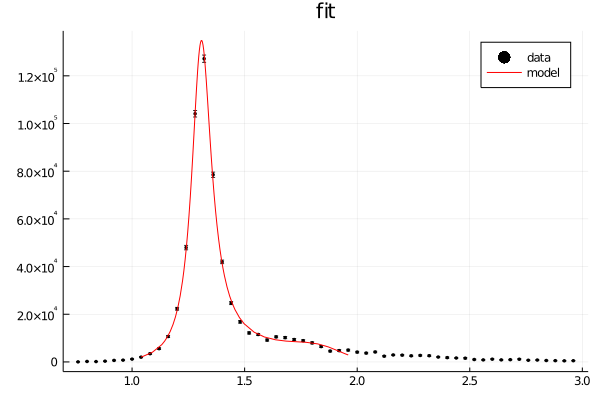

In [354]:
let 
    pars=(N0=bestpars[1], ps=bestpars[2:end])
    scatter(tdata.mηπ, tdata.I, yerr=tdata.δI, lc=:black, m=(2,:black), label="data")
    xmin, xmax = settings["data"].mηπ[[1,end]]
    plot!(bestmodel2, xmin, xmax, l=:red, label="model", title="fit")
end

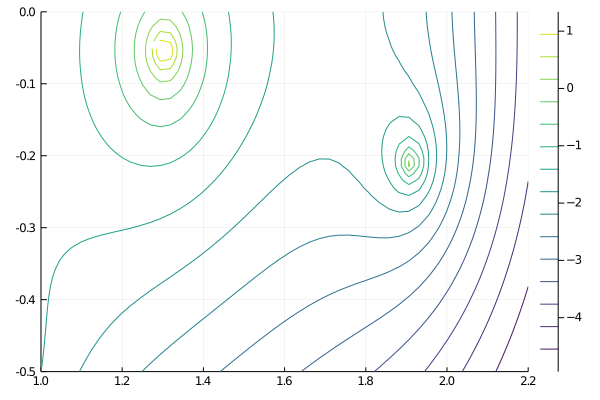

In [355]:
let
    realmv = range(1.0,2.2, length=50)
    imagmv = range(-0.5,0, length=50)
    calv = [bestA2(r+1im*i) for i in imagmv, r in realmv]
    calv = log10.(abs2.(calv))
    contour(realmv, imagmv, calv)
end

In [356]:
a2′pole_fr = Optim.optimize(x->abs2(1/bestA2(x[1]+1im*x[2])), [1.9, -0.2])

 * Status: success

 * Candidate solution
    Final objective value:     2.801086e-09

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    41
    f(x) calls:    86


In [357]:
Optim.minimizer(a2′pole_fr) .* [1, -2]

2-element Array{Float64,1}:
 1.9128392747606826
 0.4198793859570463